In [10]:
import requests
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
from functools import reduce
import pydov
from pydov.search.bodemlocatie import BodemlocatieSearch
from pydov.search.bodemobservatie import BodemobservatieSearch
import owslib

# Indien u werkt op het netwerk van de Vlaamse overheid dient u hier een proxy toe te voegen om de services aan te spreken.

# pas onderstaande lijnen aan om data van uw eigen gazondolk op te vragen
bodemlocatie_pk = "2021-033481"
# bodemlocatie_pk = "GEEF HIER DE PERM_KEY VAN UW BODEMLOCATIE"

In [11]:
def get_json(url):
    r = requests.get(url)
    if r.status_code in [403, 404]:
        print(url)
        raise ValueError("unknown permKey")
    try:
        data = r.json()
    except Exception:
        print(url)
        raise ValueError("cannot parse response to json")
    return r.json()

In [12]:
# opvragen van de metadata van de bodemlocatie
bodemlocatie_pk_full = "https://www.dov.vlaanderen.be/data/bodemlocatie/%s" % bodemlocatie_pk
bodemlocatie = BodemlocatieSearch()
pydov.cache.clean()
query = owslib.fes2.PropertyIsEqualTo(propertyname='pkey_bodemlocatie',
                          literal=bodemlocatie_pk_full)
df = bodemlocatie.search(query=query, max_features=10)
print(df.iloc[0])

[000/001] .
[000/001] c
pkey_bodemlocatie    https://www.dov.vlaanderen.be/data/bodemlocati...
pkey_bodemsite       https://www.dov.vlaanderen.be/data/bodemsite/2...
naam                                                    CN_242120_2021
type                                                            boring
waarnemingsdatum                                            2021-04-03
doel                           bodemchemisch en bodemfysisch onderzoek
x                                                            113779.74
y                                                            198644.26
mv_mtaw                                                           7.07
erfgoed                                                          False
bodemstreek                                                 Zandstreek
invoerdatum                                                 2023-09-29
educatieve_waarde                                                  NaN
Name: 0, dtype: object


In [13]:
# opvragen van de bodemobservaties die gekoppeld zijn aan de bodemlocatie
pydov.cache.clean()
bodemobservatie = BodemobservatieSearch()
query = owslib.fes2.PropertyIsEqualTo(propertyname='pkey_bodemlocatie',
                          literal=bodemlocatie_pk_full)
bodemobservaties = bodemobservatie.search(query=query, max_features=50)
print("%s bodemobservaties gevonden" % len(bodemobservaties))

[000/001] .
[000/009] ccccccccc
11 bodemobservaties gevonden


In [14]:
# weergeven van organisch koolstof, en laserfractiemetingen (ofwel NIRS ofwel gewone laser)
orgkoolstof = bodemobservaties[bodemobservaties['parameter']=='Organische C - percentage']
for i, ok in orgkoolstof.iterrows():
    print(" - Organisch C: %s %%" % ok['waarde'])

fractiemetingen = bodemobservaties[bodemobservaties['methode']=='Textuurfracties volumeprocent afgeleid op basis van NIRS'].sort_values("fractiemeting_ondergrens")
if len(fractiemetingen):
    print(" - Textuurmeting (NIRS):")
    for i, fr in fractiemetingen.iterrows():
        print("   - fractie %s tot %s: %s %%" % (fr['fractiemeting_ondergrens'], fr['fractiemeting_bovengrens'], fr['fractiemeting_waarde']))
        
fractiemetingen = bodemobservaties[bodemobservaties['methode']=='Laserdiffractie bodem'].sort_values("fractiemeting_ondergrens")
if len(fractiemetingen):
    print(" - Textuurmeting (laser):")
    for i, fr in fractiemetingen.iterrows():
        print("   - fractie %s tot %s: %s %%" % (fr['fractiemeting_ondergrens'], fr['fractiemeting_bovengrens'], fr['fractiemeting_waarde']))

 - Organisch C: 1.672 %
 - Textuurmeting (NIRS):
   - fractie 0.0 tot 6.0: 7.935155 %
   - fractie 6.0 tot 63.0: 19.8 %
   - fractie 63.0 tot 2000.0: 72.24771 %


In [15]:
# opvragen van de sensoren die op de bodemlocatie gekoppeld zitten (via de gazondolk)
url = "https://services.dov.vlaanderen.be/hfmetingen/meetreeksen/bodemlocatie/%s/sensortypes" % bodemlocatie_pk
sensors = get_json(url)
print('%s sensors gevonden' % len(sensors))

4 sensors gevonden


In [16]:
# ophalen van de bijhorende tijdreeksen
for s in sensors:
    paramid = s['parameter']['code']
    paramname = s['parameter']['beschrijving']
    sensorid = s['sensorIdentificatie']['code']
    sensorname = s['sensorIdentificatie']['beschrijving']
    print("downloading %s - %s" % (paramname, sensorname))
    url = "https://services.dov.vlaanderen.be/hfmetingen/meetreeksen/bodemlocatie/%s/parameters/%s/sensortypes/%s/meetpunten" % (bodemlocatie_pk, paramid, sensorid)
    data = get_json(url)
    df = pd.DataFrame(data['meetdata'])[['tijd', 'waarde']]
    df['timestamp'] = pd.to_datetime(df['tijd'], format='%Y-%m-%dT%H:%M:%S.000Z')
    df = df.set_index('timestamp')
    df = df[['waarde']].rename(columns={'waarde': sensorid})
    s['tijdreeks'] = df

downloading Volumetrisch vochtgehalte - Curieuzeneuzen volumetrisch vochtgehalte 0-10 cm bodemlaag
downloading Temperatuur - Curieuzeneuzen temperatuur 12 cm boven maaiveld
downloading Temperatuur - Curieuzeneuzen temperatuur op maaiveld
downloading Temperatuur - Curieuzeneuzen temperatuur 10 cm onder maaiveld


In [17]:
# tijdreeksen wegschrijven naar een csv-bestand
meetreeksen = [s['tijdreeks'] for s in sensors]
df = reduce(lambda left, right: left.join(right, how='outer'), meetreeksen)
df.to_csv('tijdreeksen_%s.csv' % bodemlocatie_pk)

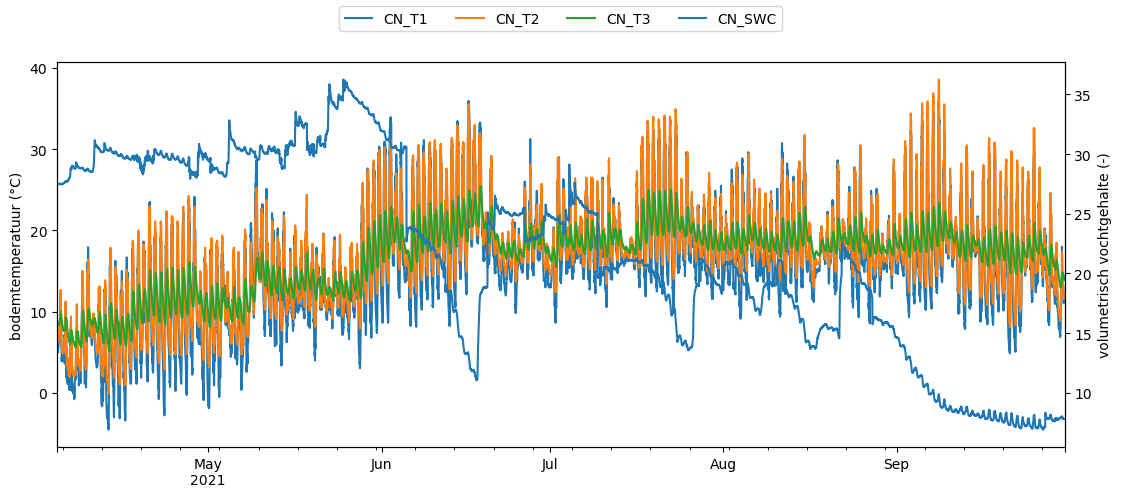

In [18]:
# tijdreeksen samen op een grafiek tonen
fig, ax = plt.subplots(figsize=[13,5])
ax2=ax.twinx()
for s in sensors:
    paramid = s['parameter']['code']
    paramname = s['parameter']['beschrijving']
    sensorid = s['sensorIdentificatie']['code']
    sensorname = s['sensorIdentificatie']['beschrijving']

    used_ax = ax
    if paramname != 'Temperatuur':
        used_ax = ax2
    s['tijdreeks'].plot(ax=used_ax, label=sensorid)
ax.get_legend().remove()
ax2.get_legend().remove()
ax.set_ylabel('bodemtemperatuur (°C)')
ax2.set_ylabel('volumetrisch vochtgehalte (-)')
ax.xaxis.label.set_visible(False)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
fig.legend(loc="upper center", ncol=5)